# Unified Arivale T2D protein set analysis

Target protein sets: for T2D, they might come from:
1. Most common outliers among T2D samples
2. Most common outliers among high-HbA1C samples
3. Overexpressed proteins/metabolites for a matched differential expression study between T2D and non-T2D samples, matched by age/sex
4. Overexpressed proteins/metabolites from differential expression between high-HbA1C and normal-HbA1C samples (same matching)
5. Proteins that have a positive LASSO coefficient for predicting next-time-point HbA1C
6. (TODO: find a known baseline set of proteins associated with T2D? Use some gene sets from msigDB)
- KEGG type 2 diabetes: https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/KEGG_TYPE_II_DIABETES_MELLITUS.html
- Wikipathways type 2 diabetes: https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/WP_TYPE_II_DIABETES_MELLITUS.html 

Problems:

- These are gene sets, not protein sets (simple enough, just translate them to uniprot)
- What if these gene sets are themselves components of SPOKE? So there will be an automatic shortcut. Potential solution: use biological spoke (spoke_2021_b_biological_objects.jsonl.gz)

Knowledge graphs - SPOKE-2021, SPOKE-2021-bio, SPOKE-2023-human

Sampling strategy for the permutation test: All proteins in the graph, all Arivale-measured proteins (does not scale to other experimental methods?), all proteins with degree distribution matched to the target proteins (call this matched-degree)

Metrics: currently, this is just the pairwise shortest path distance for all pairs within the protein set. Maybe we could add community detection? Maybe we could use node embeddings? Like, do the nodes have similar node embeddings to each other? Also, we could try to use "shortest path to T2D node" as another metric?


In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe
import matplotlib.pyplot as plt

from importlib import reload
reload(kgfe)

<module 'kgfe' from '/home/yjzhang/isb/kg_feature_engineering/src/kgfe/__init__.py'>

## 1. Load SPOKE-2021

In [2]:
spoke_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

In [3]:
spoke_graph_ud = spoke_graph.copy()
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')
spoke_graph_ud_connected = kgfe.graph_info.largest_component(spoke_graph_ud)

In [4]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)

In [5]:
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein')
chembl_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Compound')

In [6]:
t2d_node_id = names_to_ids['type 2 diabetes mellitus']

## 2. Load datasets

### Dataset 1: Arivale high-HbA1C Outliers

In [7]:
prots_hba1c_outliers = pd.read_csv('../data/prots_hba1c_outliers_2023_07_21.csv', index_col=0)
mets_hba1c_outliers = pd.read_csv('../data/mets_hba1c_outliers_2023_07_21.csv', index_col=0)

top_prots = prots_hba1c_outliers.sort_values('outlier_frequency_in_diabetes', ascending=False).head(20)
top_mets = mets_hba1c_outliers.sort_values('outlier_frequency_in_diabetes', ascending=False).head(20)

high_prots = top_prots['uniprot']
high_chems = top_mets[(~top_mets['CHEMBL'].isna())]['CHEMBL']
high_chems_kegg = top_mets[(~top_mets['KEGG'].isna())]['KEGG']

In [8]:
top_prots.head()

,name,uniprot,gene_name,outlier_frequency_in_diabetes,outlier_frequency_in_pre_diab
index,,,,,
CVD3_Q99988,CVD3_Q99988,Q99988,GDF15,0.302521,0.150538
CVD3_P07339,CVD3_P07339,P07339,CTSD,0.243697,0.139785
CVD2_P18510,CVD2_P18510,P18510,IL1RN,0.226891,0.086022
CVD2_Q9UJM8,CVD2_Q9UJM8,Q9UJM8,HAO1,0.218487,0.107527
CVD2_Q9BYF1,CVD2_Q9BYF1,Q9BYF1,ACE2,0.210084,0.139785


In [9]:
prots_hba1c_outliers_spoke_ids = [uniprot_to_ids[x] for x in high_prots]
all_prots_spoke_ids = [uniprot_to_ids[x] for x in prots_hba1c_outliers['uniprot'] if x in uniprot_to_ids]

high_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in high_chems if  x in chembl_to_ids]
mapped_chems = set([x[0] for x in high_chems_spoke_ids])
high_chems_kegg_spoke_ids = [(x, chembl_to_ids[x]) for x in top_mets['KEGG'] if  x in chembl_to_ids and x not in mapped_chems]

chems_hba1c_outliers_spoke_ids = high_chems_spoke_ids + high_chems_kegg_spoke_ids

outputs: `prots_hba1c_outliers_spoke_ids`, `chems_hba1c_outliers_spoke_ids`

### Dataset 2: Arivale T2D Diffexp

In [10]:
prots_diffexp_data = pd.read_csv('../data/prots_diffexp_t2d_hba1c_2023_08_01.csv')

In [11]:
prots_diffexp_data = prots_diffexp_data.sort_values('t2d_minus_control', ascending=False)

In [12]:
min_diff_threshold = prots_diffexp_data.t2d_minus_control.quantile(0.9)
max_pval_threshold = prots_diffexp_data.t2d_minus_control_pvals.quantile(0.1)
print(min_diff_threshold, max_pval_threshold)

0.4556678214285714 2.1699080596166666e-05


In [13]:
prots_diffexp_data[(prots_diffexp_data.t2d_minus_control > min_diff_threshold) &\
                   (prots_diffexp_data.t2d_minus_control_pvals < max_pval_threshold)].shape

(18, 7)

In [14]:
prots_diffexp_high = prots_diffexp_data[(prots_diffexp_data.t2d_minus_control > min_diff_threshold) & (prots_diffexp_data.t2d_minus_control_pvals < 1e-4)]

In [15]:
prots_t2d_diffexp_spoke_ids = [uniprot_to_ids[x] for x in prots_diffexp_high.uniprot]

outputs: `prots_t2d_diffexp_spoke_ids`

### Dataset 3: Arivale high-HbA1C Diffexp

In [16]:
min_diff_threshold = prots_diffexp_data.high_hba1c_minus_control.quantile(0.9)
max_pval_threshold = prots_diffexp_data.high_hba1c_minus_control_pvals.quantile(0.1)
print(min_diff_threshold, max_pval_threshold)

0.44284914393939423 0.00033190095600044004


In [17]:
prots_diffexp_data[(prots_diffexp_data.high_hba1c_minus_control > min_diff_threshold) & \
                   (prots_diffexp_data.high_hba1c_minus_control_pvals < max_pval_threshold)].shape

(18, 7)

In [18]:
prots_diffexp_hba1c_high = prots_diffexp_data[(prots_diffexp_data.high_hba1c_minus_control > min_diff_threshold) & \
                                              (prots_diffexp_data.high_hba1c_minus_control_pvals < max_pval_threshold)]

In [19]:
prots_hba1c_diffexp_spoke_ids = [uniprot_to_ids[x] for x in prots_diffexp_hba1c_high.uniprot]

outputs: `prots_hba1c_diffexp_spoke_ids`

### Dataset 4: Predictors of next-HbA1C identified by LASSO

In [20]:
lasso_weights = pd.read_csv('../data/prots_lassocv_hba1c_top_weights.csv', index_col=0)

In [21]:
top_prots = lasso_weights[lasso_weights.weight > 0]
prots_lasso_spoke_ids = [uniprot_to_ids[x] for x in top_prots.uniprot]


outputs: `prots_lasso_spoke_ids`

### Dataset 5: Genes associated with T2D pathways from KEGG

In [22]:
uniprot_table = pd.read_csv('../processed_graphs/uniprot_genes.csv')
gene_to_uniprot = {x.subject_name : x.object_id for i, x in uniprot_table.iterrows()}

In [23]:
with open('../data/KEGG_TYPE_II_DIABETES_MELLITUS.v2023.1.Hs.grp') as f:
    kegg_t2d_genes = [x.strip() for x in f.readlines()]

kegg_t2d_prots = [gene_to_uniprot[x] for x in kegg_t2d_genes]

kegg_t2d_spoke_ids = [uniprot_to_ids[x] for x in kegg_t2d_prots if x in uniprot_to_ids]

In [24]:
with open('../data/WP_TYPE_II_DIABETES_MELLITUS.v2023.1.Hs.grp') as f:
    wp_t2d_genes = [x.strip() for x in f.readlines()]

wp_t2d_prots = [gene_to_uniprot[x] for x in wp_t2d_genes]

wp_t2d_spoke_ids = [uniprot_to_ids[x] for x in wp_t2d_prots if x in uniprot_to_ids]

In [25]:
print(len(kegg_t2d_spoke_ids), len(wp_t2d_spoke_ids))

45 21


outputs: `kegg_t2d_spoke_ids`

## Plotting venn diagrams of the different protein sets

In [26]:
import matplotlib_venn

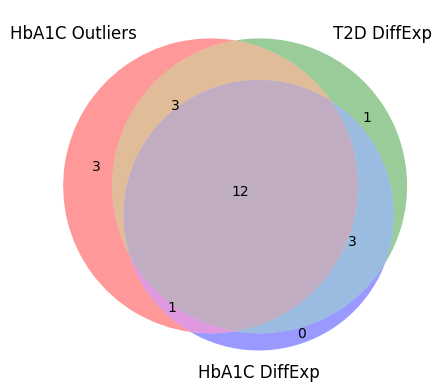

In [27]:
matplotlib_venn.venn3([set(prots_hba1c_outliers_spoke_ids), 
                       set(prots_t2d_diffexp_spoke_ids),
                       set(prots_hba1c_diffexp_spoke_ids)], ['HbA1C Outliers', 'T2D DiffExp', 'HbA1C DiffExp'])

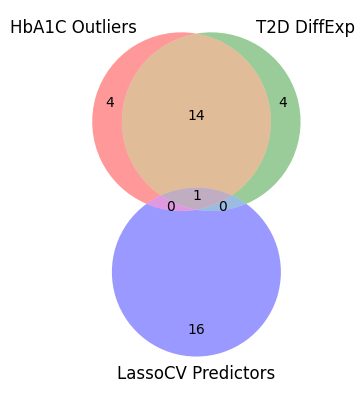

In [28]:
matplotlib_venn.venn3([set(prots_hba1c_outliers_spoke_ids), 
                       set(prots_t2d_diffexp_spoke_ids),
                       set(prots_lasso_spoke_ids)], ['HbA1C Outliers', 'T2D DiffExp', 'LassoCV Predictors'])

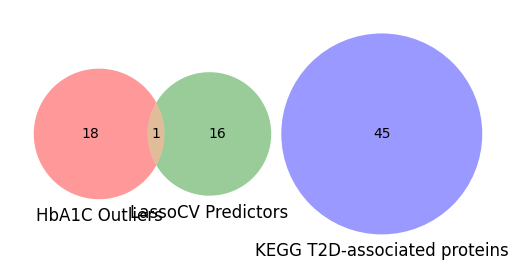

In [29]:
matplotlib_venn.venn3([set(prots_hba1c_outliers_spoke_ids), 
                       set(prots_lasso_spoke_ids),
                       set(kegg_t2d_spoke_ids)], ['HbA1C Outliers', 'LassoCV Predictors', 'KEGG T2D-associated proteins'])

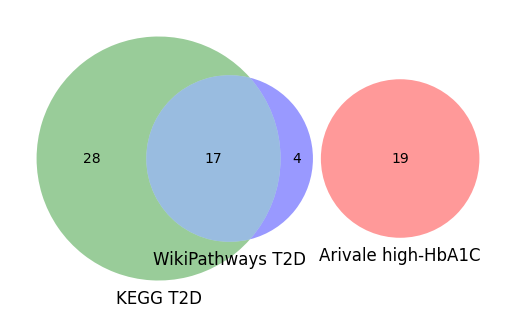

In [71]:
matplotlib_venn.venn3([set(prots_hba1c_outliers_spoke_ids), 
                       set(kegg_t2d_spoke_ids),
                       set(wp_t2d_spoke_ids)], ['Arivale high-HbA1C', 'KEGG T2D', 'WikiPathways T2D'])

## 3. Null graph model analysis, testing for protein set coherence

Do this for all datasets

### Dataset 1

In [31]:
hba1c_outliers_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(prots_hba1c_outliers_spoke_ids)),
                                                         target_nodes=[t2d_node_id])

In [32]:
hba1c_outliers_null_results_arivale_prots = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(prots_hba1c_outliers_spoke_ids),
                                                                               ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [33]:
hba1c_outliers_null_results_arivale_prots = pd.DataFrame(hba1c_outliers_null_results_arivale_prots)

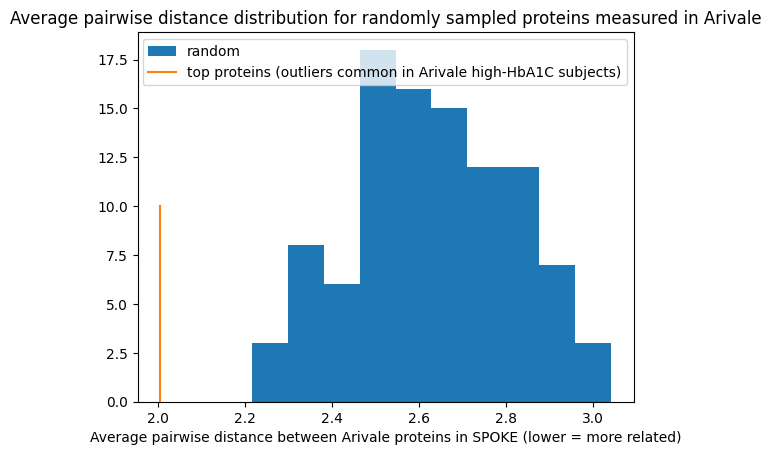

In [34]:
plt.hist(hba1c_outliers_null_results_arivale_prots.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_outliers_stats['average_pairwise_distance'], hba1c_outliers_stats['average_pairwise_distance']],
         [0, 10], label='top proteins (outliers common in Arivale high-HbA1C subjects)')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

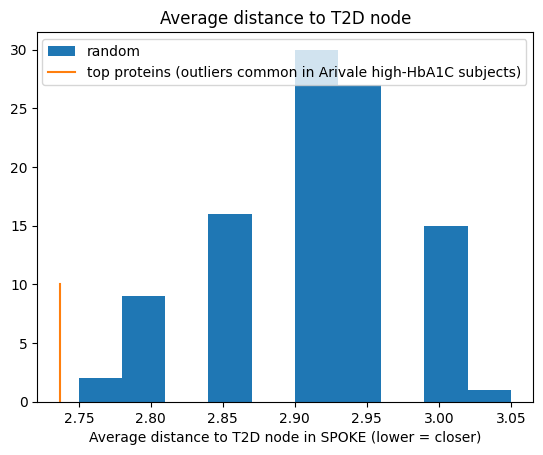

In [35]:
plt.hist(hba1c_outliers_null_results_arivale_prots.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_outliers_stats['average_target_distance'], hba1c_outliers_stats['average_target_distance']],
         [0, 10], label='top proteins (outliers common in Arivale high-HbA1C subjects)')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### Dataset 2

In [36]:
t2d_diffexp_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(prots_t2d_diffexp_spoke_ids)),
                                                      target_nodes=[t2d_node_id])

In [37]:
t2d_diffexp_null_results_arivale_prots = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                            len(prots_t2d_diffexp_spoke_ids),
                                                                            ids_subset=all_prots_spoke_ids,
                                                                            target_nodes=[t2d_node_id])

In [38]:
t2d_diffexp_null_results_arivale_prots = pd.DataFrame(t2d_diffexp_null_results_arivale_prots)


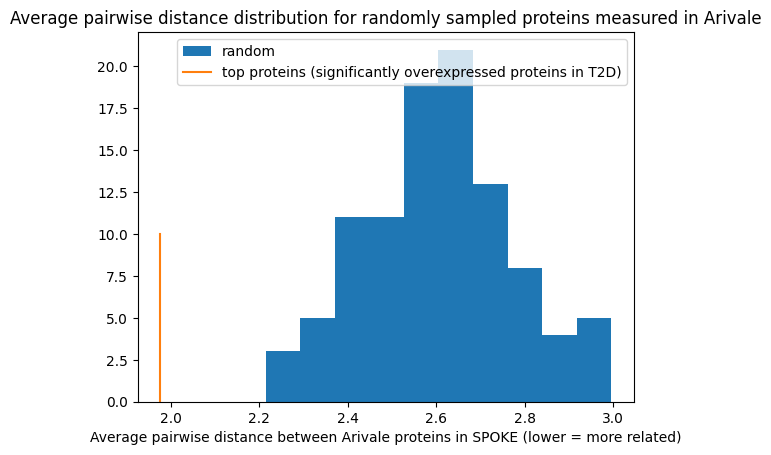

In [39]:
plt.hist(t2d_diffexp_null_results_arivale_prots.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([t2d_diffexp_stats['average_pairwise_distance'], t2d_diffexp_stats['average_pairwise_distance']],
         [0, 10], label='top proteins (significantly overexpressed proteins in T2D)')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

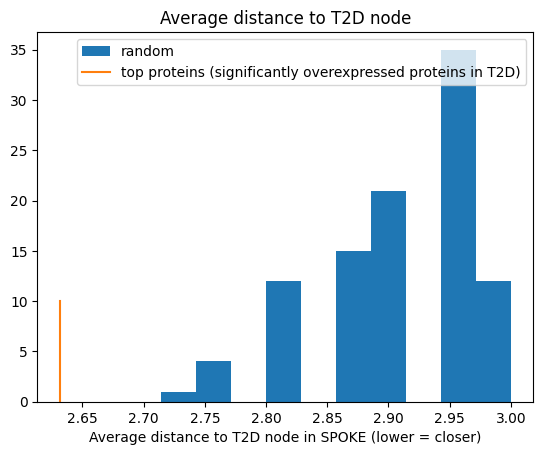

In [66]:
plt.hist(t2d_diffexp_null_results_arivale_prots.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([t2d_diffexp_stats['average_target_distance'], t2d_diffexp_stats['average_target_distance']],
         [0, 10], label='top proteins (significantly overexpressed proteins in T2D)')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### Dataset 3

In [41]:
hba1c_diffexp_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(prots_hba1c_diffexp_spoke_ids)),
                                                        target_nodes=[t2d_node_id])

In [42]:
hba1c_diffexp_null_results_arivale_prots = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                              len(prots_hba1c_diffexp_spoke_ids),
                                                                              ids_subset=all_prots_spoke_ids,
                                                                              target_nodes=[t2d_node_id])

In [43]:
hba1c_diffexp_null_results_arivale_prots = pd.DataFrame(hba1c_diffexp_null_results_arivale_prots)


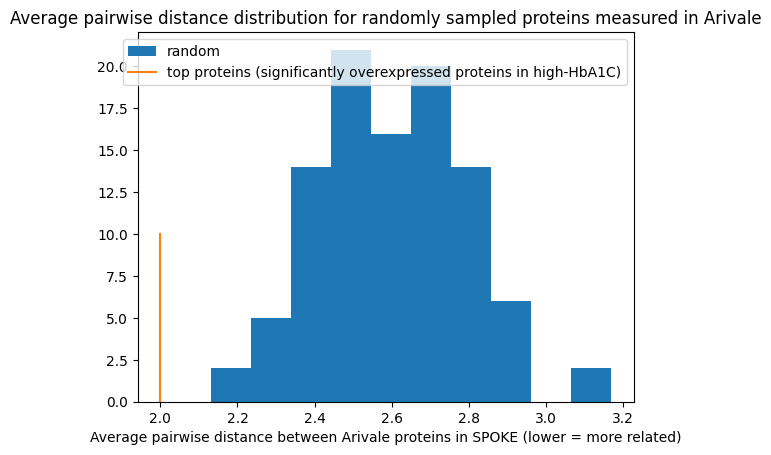

In [44]:
plt.hist(hba1c_diffexp_null_results_arivale_prots.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_diffexp_stats['average_pairwise_distance'], hba1c_diffexp_stats['average_pairwise_distance']],
         [0, 10], label='top proteins (significantly overexpressed proteins in high-HbA1C)')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

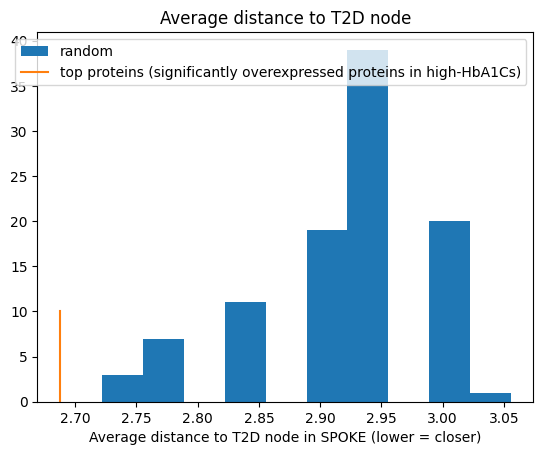

In [65]:
plt.hist(hba1c_diffexp_null_results_arivale_prots.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_diffexp_stats['average_target_distance'], hba1c_diffexp_stats['average_target_distance']],
         [0, 10], label='top proteins (significantly overexpressed proteins in high-HbA1Cs)')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### Dataset 4

In [46]:
hba1c_lasso_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(prots_lasso_spoke_ids)),
                                                      target_nodes=[t2d_node_id])

In [47]:
hba1c_lasso_null_results_arivale_prots = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                            len(prots_lasso_spoke_ids),
                                                                            ids_subset=all_prots_spoke_ids,
                                                                            target_nodes=[t2d_node_id])

In [48]:
hba1c_lasso_null_results_arivale_prots = pd.DataFrame(hba1c_lasso_null_results_arivale_prots)


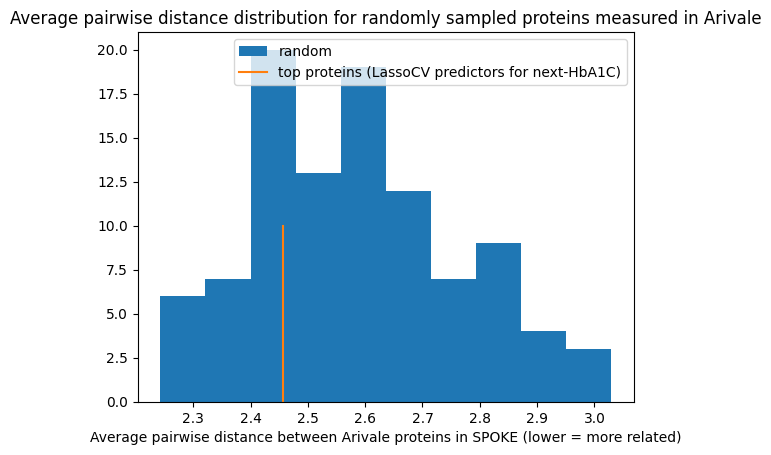

In [49]:
plt.hist(hba1c_lasso_null_results_arivale_prots.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_lasso_stats['average_pairwise_distance'], hba1c_lasso_stats['average_pairwise_distance']],
         [0, 10], label='top proteins (LassoCV predictors for next-HbA1C)')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

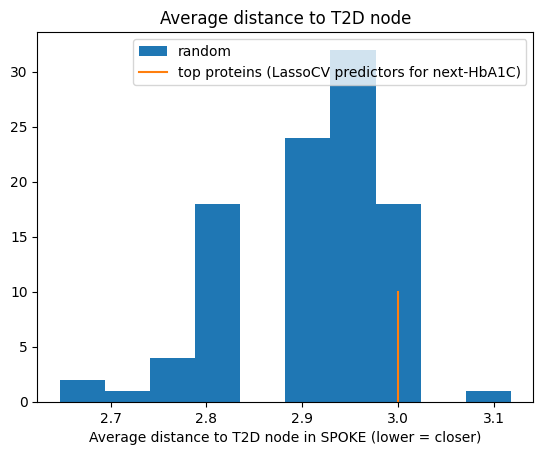

In [64]:
plt.hist(hba1c_lasso_null_results_arivale_prots.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_lasso_stats['average_target_distance'], hba1c_lasso_stats['average_target_distance']],
         [0, 10], label='top proteins (LassoCV predictors for next-HbA1C)')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### Dataset 5

In [51]:
kegg_t2d_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(kegg_t2d_spoke_ids)),
                                                   target_nodes=[t2d_node_id])

In [52]:
# this takes 10 minutes
kegg_t2d_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',\
                                                                 len(kegg_t2d_spoke_ids),\
                                                                 use_degree_sampling=True,\
                                                                 input_id_set=kegg_t2d_spoke_ids,
                                                                 target_nodes=[t2d_node_id])

In [53]:
kegg_t2d_null_results = pd.DataFrame(kegg_t2d_null_results)


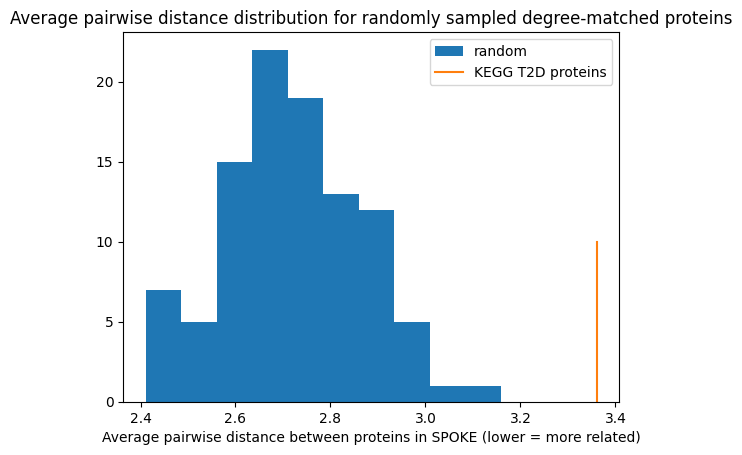

In [54]:
plt.hist(kegg_t2d_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled degree-matched proteins')
plt.plot([kegg_t2d_stats['average_pairwise_distance'], kegg_t2d_stats['average_pairwise_distance']],
         [0, 10], label='KEGG T2D proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.legend()

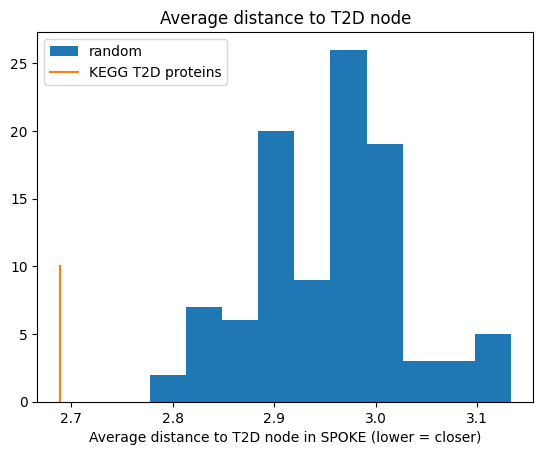

In [61]:
plt.hist(kegg_t2d_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([kegg_t2d_stats['average_target_distance'], kegg_t2d_stats['average_target_distance']],
         [0, 10], label='KEGG T2D proteins')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

In [56]:
wp_t2d_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(wp_t2d_spoke_ids)),
                                                 target_nodes=[t2d_node_id])

In [57]:
# this takes 7 minutes
wp_t2d_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                         len(wp_t2d_spoke_ids),
                                                         use_degree_sampling=True,
                                                         input_id_set=wp_t2d_spoke_ids,
                                                         target_nodes=[t2d_node_id])

In [58]:
wp_t2d_null_results = pd.DataFrame(wp_t2d_null_results)


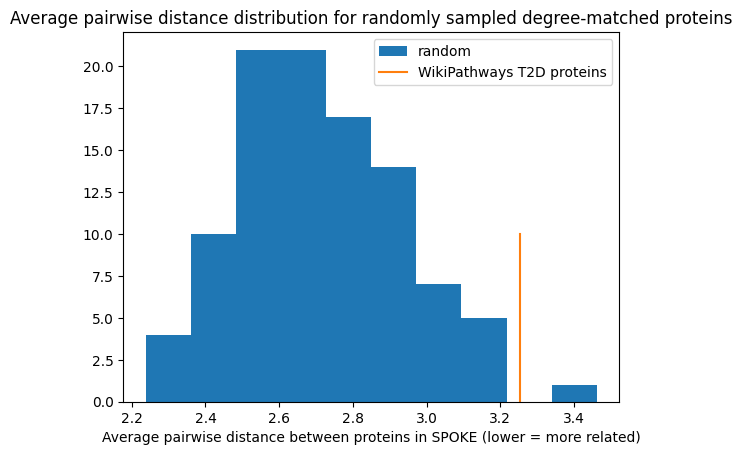

In [59]:
plt.hist(wp_t2d_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled degree-matched proteins')
plt.plot([wp_t2d_stats['average_pairwise_distance'], wp_t2d_stats['average_pairwise_distance']],
         [0, 10], label='WikiPathways T2D proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.legend()

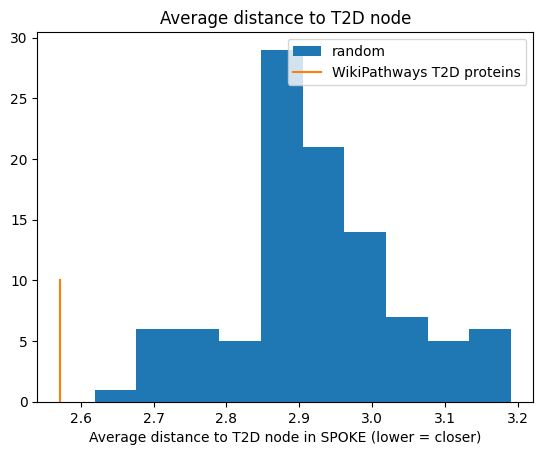

In [63]:
plt.hist(wp_t2d_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([wp_t2d_stats['average_target_distance'], wp_t2d_stats['average_target_distance']],
         [0, 10], label='WikiPathways T2D proteins')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()